**Chapter 1 – The Machine Learning landscape**

_This notebook contains the code examples in chapter 1. You'll also find the exercise solutions at the end of the notebook. The rest of this notebook is used to generate `lifesat.csv` from the original data sources, and some of this chapter's figures._

You're welcome to go through the code in this notebook if you want, but the real action starts in the next chapter.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/01_the_machine_learning_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/01_the_machine_learning_landscape.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

Scikit-Learn ≥1.0.1 is required:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Let's define the default font sizes, to plot pretty figures:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Make this notebook's output stable across runs:

In [ ]:
import numpy as np

np.random.seed(42)

# Code example 1-1


=== Countries ABOVE the best-fit line (happier than predicted) ===
       Country  GDP per capita (USD)  Life satisfaction  Residual (actual - predicted)
        Israel          38341.307570                7.2                       0.851832
   New Zealand          42404.393738                7.3                       0.676399
       Finland          47260.800458                7.6                       0.647188
        Canada          45856.625626                7.4                       0.542376
        Russia          26456.387938                5.8                       0.257499
     Australia          48697.837028                7.3                       0.249773
United Kingdom          41627.129269                6.8                       0.229089
       Iceland          52279.728851                7.5                       0.206960
        Poland          32238.157259                6.1                       0.165558
        Latvia          29932.493910                5.9       

/tmp/ipython-input-3613549416.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pop_group, group_df in merged_df.groupby("Population group", sort=False):


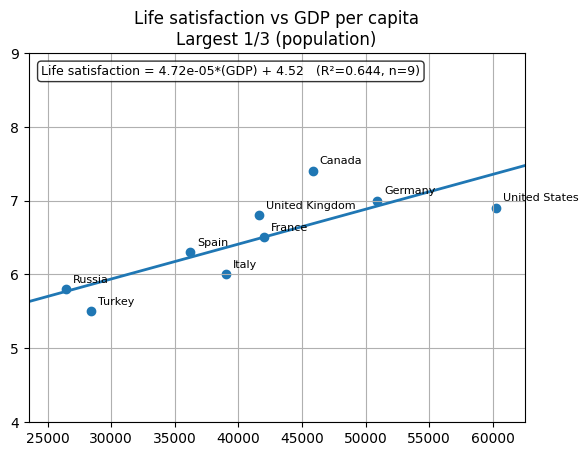

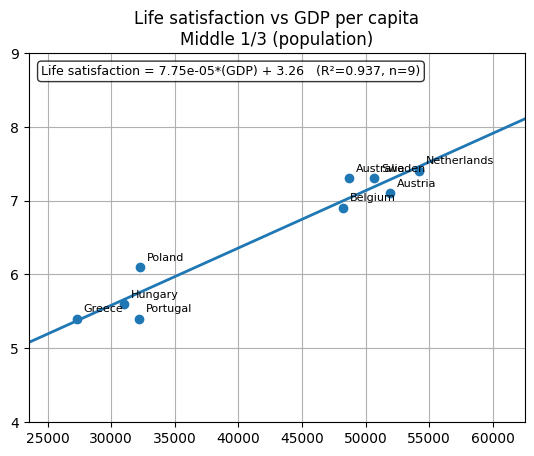

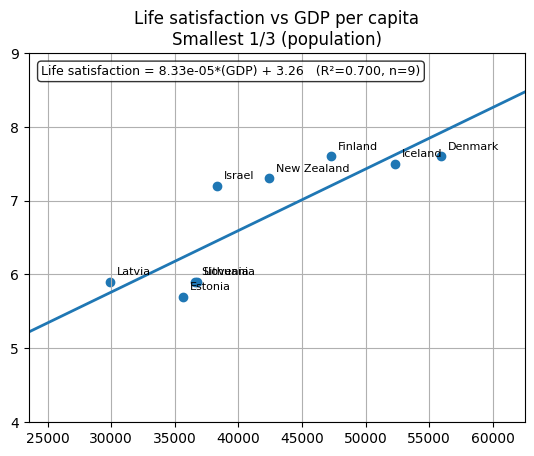

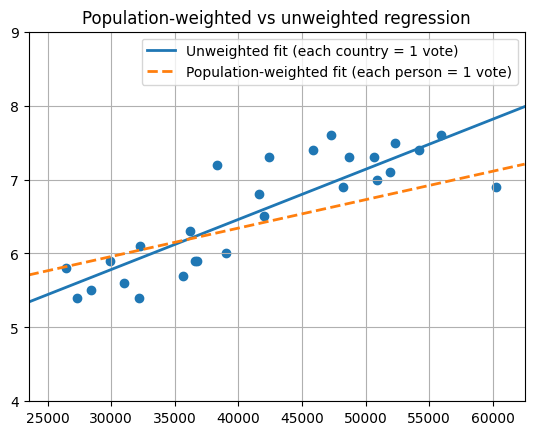

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# -------------------------
# 1) Load life satisfaction dataset (Ageron)
# -------------------------
data_root_url = "https://github.com/ageron/data/raw/main/"
life_satisfaction_df = pd.read_csv(data_root_url + "lifesat/lifesat.csv")

# Use 1D arrays for convenience
gdp_per_capita_usd = life_satisfaction_df["GDP per capita (USD)"].to_numpy()
life_satisfaction_score = life_satisfaction_df["Life satisfaction"].to_numpy()
gdp_per_capita_usd_2d = gdp_per_capita_usd.reshape(-1, 1)

# -------------------------
# 2) Fit baseline model and compute residuals
# -------------------------
baseline_model = LinearRegression()
baseline_model.fit(gdp_per_capita_usd_2d, life_satisfaction_score)

baseline_predicted = baseline_model.predict(gdp_per_capita_usd_2d)
residuals = life_satisfaction_score - baseline_predicted  # + means above line, - means below line

diagnostics_df = life_satisfaction_df.copy()
diagnostics_df["Predicted satisfaction"] = baseline_predicted
diagnostics_df["Residual (actual - predicted)"] = residuals

# -------------------------
# 3) List countries above / below the best-fit line
# -------------------------
above_line_df = diagnostics_df[diagnostics_df["Residual (actual - predicted)"] > 0].copy()
below_line_df = diagnostics_df[diagnostics_df["Residual (actual - predicted)"] < 0].copy()

above_line_df = above_line_df.sort_values("Residual (actual - predicted)", ascending=False)
below_line_df = below_line_df.sort_values("Residual (actual - predicted)")  # most negative first

print("\n=== Countries ABOVE the best-fit line (happier than predicted) ===")
print(above_line_df[["Country", "GDP per capita (USD)", "Life satisfaction", "Residual (actual - predicted)"]].to_string(index=False))

print("\n=== Countries BELOW the best-fit line (less happy than predicted) ===")
print(below_line_df[["Country", "GDP per capita (USD)", "Life satisfaction", "Residual (actual - predicted)"]].to_string(index=False))

# -------------------------
# 4) Pull population data (OWID) and merge it in
#    OWID CO2 dataset includes: country, year, iso_code, population ...
# -------------------------
owid_co2_url = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"
owid_df = pd.read_csv(owid_co2_url, usecols=["country", "year", "iso_code", "population"])

# Remove aggregate regions (OWID_* codes)
owid_df = owid_df[~owid_df["iso_code"].astype(str).str.startswith("OWID")].copy()

population_year = 2020  # choose a year to line up with your GDP example year
population_df = (
    owid_df[owid_df["year"] == population_year][["country", "population"]]
    .dropna()
    .drop_duplicates(subset=["country"])
    .rename(columns={"country": "JoinCountry", "population": "Population"})
)

# Country-name fixes (add to this list if you see missing populations)
country_name_fixes = {
    "Korea": "South Korea",
    "Czech Republic": "Czechia",
    "Slovak Republic": "Slovakia",
    "Russian Federation": "Russia",
}

life_satisfaction_df["JoinCountry"] = life_satisfaction_df["Country"].replace(country_name_fixes)

merged_df = life_satisfaction_df.merge(population_df, on="JoinCountry", how="left")

# Report any countries that failed to match population
missing_pop = merged_df[merged_df["Population"].isna()]["Country"].tolist()
if missing_pop:
    print("\n=== NOTE: These countries are missing population matches (add to country_name_fixes) ===")
    print(missing_pop)

# Keep only rows with population so terciles work
merged_df = merged_df.dropna(subset=["Population"]).copy()

# -------------------------
# 5) Split into population terciles and fit separate lines
# -------------------------
merged_df["Population group"] = pd.qcut(
    merged_df["Population"],
    3,
    labels=["Smallest 1/3 (population)", "Middle 1/3 (population)", "Largest 1/3 (population)"]
)

plot_gdp_min_usd, plot_gdp_max_usd = 23_500, 62_500
gdp_for_line = np.linspace(plot_gdp_min_usd, plot_gdp_max_usd, 200).reshape(-1, 1)

for pop_group, group_df in merged_df.groupby("Population group", sort=False):
    group_gdp_2d = group_df[["GDP per capita (USD)"]].to_numpy()
    group_satisfaction = group_df["Life satisfaction"].to_numpy()

    group_model = LinearRegression()
    group_model.fit(group_gdp_2d, group_satisfaction)

    group_line = group_model.predict(gdp_for_line)

    slope = group_model.coef_[0]
    intercept = group_model.intercept_
    r2 = group_model.score(group_gdp_2d, group_satisfaction)

    equation_text = f"Life satisfaction = {slope:.2e}*(GDP) + {intercept:.2f}   (R²={r2:.3f}, n={len(group_df)})"

    fig, ax = plt.subplots()
    ax.scatter(group_df["GDP per capita (USD)"], group_df["Life satisfaction"])
    ax.plot(gdp_for_line, group_line, linewidth=2)

    # label points (handy when n is small like this dataset)
    for _, row in group_df.iterrows():
        ax.annotate(row["Country"], (row["GDP per capita (USD)"], row["Life satisfaction"]),
                    xytext=(5, 5), textcoords="offset points", fontsize=8)

    ax.set_title(f"Life satisfaction vs GDP per capita\n{pop_group}")
    ax.set_xlim(plot_gdp_min_usd, plot_gdp_max_usd)
    ax.set_ylim(4, 9)
    ax.grid(True)

    ax.text(plot_gdp_min_usd + 1000, 8.7, equation_text,
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.show()

# -------------------------
# 6) BONUS OPTION: population-weighted best-fit line (each person counts, not each country)
# -------------------------
weighted_model = LinearRegression()
weighted_model.fit(
    merged_df[["GDP per capita (USD)"]].to_numpy(),
    merged_df["Life satisfaction"].to_numpy(),
    sample_weight=merged_df["Population"].to_numpy()
)

weighted_line = weighted_model.predict(gdp_for_line)

fig, ax = plt.subplots()
ax.scatter(merged_df["GDP per capita (USD)"], merged_df["Life satisfaction"])
ax.plot(gdp_for_line, baseline_model.predict(gdp_for_line), linewidth=2, label="Unweighted fit (each country = 1 vote)")
ax.plot(gdp_for_line, weighted_line, linewidth=2, linestyle="--", label="Population-weighted fit (each person = 1 vote)")
ax.set_title("Population-weighted vs unweighted regression")
ax.set_xlim(plot_gdp_min_usd, plot_gdp_max_usd)
ax.set_ylim(4, 9)
ax.grid(True)
ax.legend()
plt.show()



=== Potential outliers / influential points (ranked) ===
      Country  GDP per capita (USD)  Life satisfaction  Residual  Std residual  Cook's distance
United States          60235.728492                6.9 -0.932369     -2.331892         0.708694


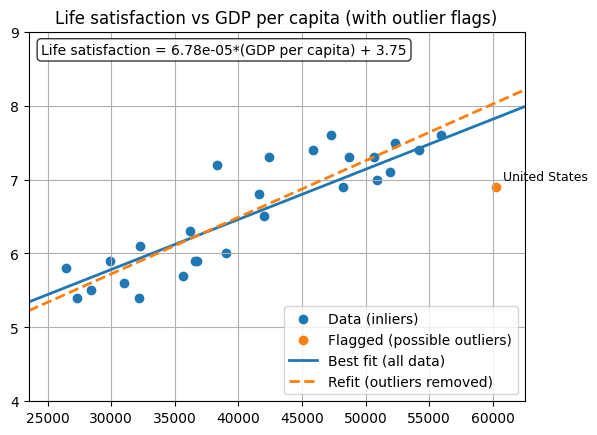

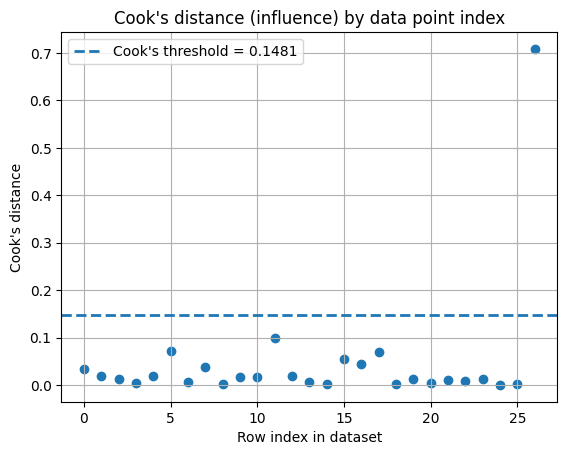

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# -------------------------
# 1) Load data
# -------------------------
data_root_url = "https://github.com/ageron/data/raw/main/"
life_satisfaction_df = pd.read_csv(data_root_url + "lifesat/lifesat.csv")

gdp_per_capita_usd = life_satisfaction_df["GDP per capita (USD)"].to_numpy()
life_satisfaction_score = life_satisfaction_df["Life satisfaction"].to_numpy()

# For sklearn, features must be 2D
gdp_per_capita_usd_2d = gdp_per_capita_usd.reshape(-1, 1)

# -------------------------
# 2) Fit initial model
# -------------------------
life_satisfaction_model = LinearRegression()
life_satisfaction_model.fit(gdp_per_capita_usd_2d, life_satisfaction_score)

predicted_satisfaction = life_satisfaction_model.predict(gdp_per_capita_usd_2d)
residuals = life_satisfaction_score - predicted_satisfaction

# Standardized residuals (how many "sigmas" away from the line)
residual_std = residuals.std(ddof=1)
standardized_residuals = residuals / residual_std

# -------------------------
# 3) Influence stats (Cook's distance) for simple linear regression
#    This is a common statistical way to flag points that overly influence the line.
# -------------------------
n_points = len(gdp_per_capita_usd)
n_parameters = 2  # slope + intercept

# Design matrix with intercept: [x, 1]
design_matrix = np.column_stack([gdp_per_capita_usd, np.ones(n_points)])
xtx_inv = np.linalg.inv(design_matrix.T @ design_matrix)
hat_matrix = design_matrix @ xtx_inv @ design_matrix.T
leverage = np.diag(hat_matrix)

mse = np.sum(residuals**2) / (n_points - n_parameters)
cooks_distance = (residuals**2 / (n_parameters * mse)) * (leverage / (1 - leverage)**2)

# Thresholds (tweakable)
std_resid_threshold = 2.5           # often 2 or 3; 2.5 is a nice middle
cooks_threshold = 4 / n_points      # common rule of thumb

is_outlier = (np.abs(standardized_residuals) > std_resid_threshold) | (cooks_distance > cooks_threshold)

# Add diagnostics to a new DataFrame for easy viewing
diagnostics_df = life_satisfaction_df.copy()
diagnostics_df["Predicted satisfaction"] = predicted_satisfaction
diagnostics_df["Residual"] = residuals
diagnostics_df["Std residual"] = standardized_residuals
diagnostics_df["Leverage"] = leverage
diagnostics_df["Cook's distance"] = cooks_distance
diagnostics_df["Flagged outlier"] = is_outlier

# Print the most suspicious points
outliers_ranked = diagnostics_df.loc[is_outlier].copy()
outliers_ranked["Abs std residual"] = outliers_ranked["Std residual"].abs()
outliers_ranked = outliers_ranked.sort_values(["Cook's distance", "Abs std residual"], ascending=False)

print("\n=== Potential outliers / influential points (ranked) ===")
columns_to_show = [
    "Country", "GDP per capita (USD)", "Life satisfaction",
    "Residual", "Std residual", "Cook's distance"
]
print(outliers_ranked[columns_to_show].to_string(index=False))

# -------------------------
# 4) Plot: highlight outliers and show best-fit line(s)
# -------------------------
gdp_min_usd, gdp_max_usd = 23_500, 62_500
gdp_values_for_line = np.linspace(gdp_min_usd, gdp_max_usd, 200).reshape(-1, 1)
best_fit_line = life_satisfaction_model.predict(gdp_values_for_line)

slope = life_satisfaction_model.coef_[0]
intercept = life_satisfaction_model.intercept_
equation_text = f"Life satisfaction = {slope:.2e}*(GDP per capita) + {intercept:.2f}"

fig, ax = plt.subplots()

# Inliers
ax.scatter(
    gdp_per_capita_usd[~is_outlier],
    life_satisfaction_score[~is_outlier],
    label="Data (inliers)"
)

# Outliers
ax.scatter(
    gdp_per_capita_usd[is_outlier],
    life_satisfaction_score[is_outlier],
    label="Flagged (possible outliers)"
)

# Best-fit line (all points)
ax.plot(gdp_values_for_line, best_fit_line, linewidth=2, label="Best fit (all data)")

# Optional: refit without outliers and show the "cleaned" line
if (~is_outlier).sum() >= 2:
    cleaned_model = LinearRegression()
    cleaned_model.fit(gdp_per_capita_usd_2d[~is_outlier], life_satisfaction_score[~is_outlier])
    cleaned_line = cleaned_model.predict(gdp_values_for_line)
    ax.plot(gdp_values_for_line, cleaned_line, linewidth=2, linestyle="--", label="Refit (outliers removed)")

# Label outlier countries on the plot (if the column exists)
if "Country" in life_satisfaction_df.columns:
    for _, row in diagnostics_df.loc[is_outlier].iterrows():
        ax.annotate(
            row["Country"],
            (row["GDP per capita (USD)"], row["Life satisfaction"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9
        )

# Add equation box
ax.text(
    gdp_min_usd + 1000, 8.7, equation_text,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

ax.set_title("Life satisfaction vs GDP per capita (with outlier flags)")
ax.set_xlim(gdp_min_usd, gdp_max_usd)
ax.set_ylim(4, 9)
ax.grid(True)
ax.legend()
plt.show()

# -------------------------
# 5) Extra diagnostic plot: Cook's distance
# -------------------------
fig, ax = plt.subplots()
ax.scatter(range(n_points), cooks_distance)
ax.axhline(cooks_threshold, linestyle="--", linewidth=2, label=f"Cook's threshold = {cooks_threshold:.4f}")
ax.set_title("Cook's distance (influence) by data point index")
ax.set_xlabel("Row index in dataset")
ax.set_ylabel("Cook's distance")
ax.grid(True)
ax.legend()
plt.show()


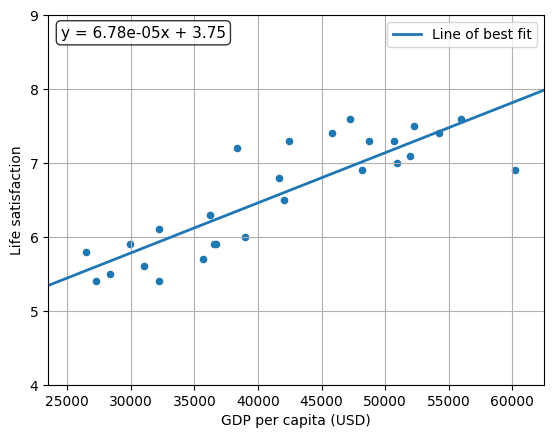

[[6.30165767]]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Download and prepare the data
data_root_url = "https://github.com/ageron/data/raw/main/"
life_satisfaction_df = pd.read_csv(data_root_url + "lifesat/lifesat.csv")

# Feature (input): GDP per capita
gdp_per_capita_usd = life_satisfaction_df[["GDP per capita (USD)"]].values

# Target (output): reported life satisfaction score
life_satisfaction_score = life_satisfaction_df[["Life satisfaction"]].values

# Select and train a linear model
life_satisfaction_model = LinearRegression()
life_satisfaction_model.fit(gdp_per_capita_usd, life_satisfaction_score)

# Define plot range for the line of best fit
gdp_min_usd, gdp_max_usd = 23_500, 62_500

# Generate GDP values across the plot range and predict corresponding satisfaction values
gdp_values_for_best_fit_line = np.linspace(gdp_min_usd, gdp_max_usd, 200).reshape(-1, 1)
predicted_satisfaction_for_best_fit_line = life_satisfaction_model.predict(gdp_values_for_best_fit_line)

# Extract equation coefficients for: y = mx + b
slope_m = life_satisfaction_model.coef_[0][0]
intercept_b = life_satisfaction_model.intercept_[0]
best_fit_equation_text = f"y = {slope_m:.2e}x + {intercept_b:.2f}"

# Visualize the data
ax = life_satisfaction_df.plot(
    kind="scatter",
    grid=True,
    x="GDP per capita (USD)",
    y="Life satisfaction"
)

# Plot the best-fit line
ax.plot(
    gdp_values_for_best_fit_line,
    predicted_satisfaction_for_best_fit_line,
    linewidth=2,
    label="Line of best fit"
)

# Set plot bounds
ax.set_xlim(gdp_min_usd, gdp_max_usd)
ax.set_ylim(4, 9)

# Add equation text to the plot
ax.text(
    gdp_min_usd + 1000,
    8.7,
    best_fit_equation_text,
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

ax.legend()
plt.show()

# Make a prediction for Cyprus
cyprus_gdp_per_capita_2020_usd = [[37_655.2]]
print(life_satisfaction_model.predict(cyprus_gdp_per_capita_2020_usd))


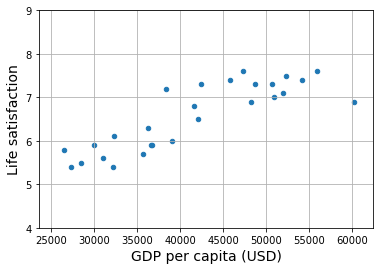

[[6.30165767]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Download and prepare the data
data_root = "https://github.com/ageron/data/raw/main/"
lifesat = pd.read_csv(data_root + "lifesat/lifesat.csv")
X = lifesat[["GDP per capita (USD)"]].values
y = lifesat[["Life satisfaction"]].values

# Visualize the data
lifesat.plot(kind='scatter', grid=True,
             x="GDP per capita (USD)", y="Life satisfaction")
plt.axis([23_500, 62_500, 4, 9])
plt.show()

# Select a linear model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[37_655.2]]  # Cyprus' GDP per capita in 2020
print(model.predict(X_new)) # outputs [[6.30165767]]

Replacing the Linear Regression model with k-Nearest Neighbors (in this example, k = 3) regression in the previous code is as simple as replacing these two
lines:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

with these two:

```python
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)
```

In [ ]:
# Select a 3-Nearest Neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=3)

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
print(model.predict(X_new)) # outputs [[6.33333333]]


[[6.33333333]]


# Generating the data and figures — please skip

This is the code I used to generate the `lifesat.csv` dataset. You can safely skip this.

Create a function to save the figures:

In [ ]:
from pathlib import Path

# Where to save the figures
IMAGES_PATH = Path() / "images" / "fundamentals"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load and prepare Life satisfaction data

To create `lifesat.csv`, I downloaded the Better Life Index (BLI) data from [OECD's website](http://stats.oecd.org/index.aspx?DataSetCode=BLI) (to get the Life Satisfaction for each country), and World Bank GDP per capita data from [OurWorldInData.org](https://ourworldindata.org/grapher/gdp-per-capita-worldbank). The BLI data is in `datasets/lifesat/oecd_bli.csv` (data from 2020), and the GDP per capita data is in `datasets/lifesat/gdp_per_capita.csv` (data up to 2020).

If you want to grab the latest versions, please feel free to do so. However, there may be some changes (e.g., in the column names, or different countries missing data), so be prepared to have to tweak the code.

In [ ]:
import urllib.request

datapath = Path() / "datasets" / "lifesat"
datapath.mkdir(parents=True, exist_ok=True)

data_root = "https://github.com/ageron/data/raw/main/"
for filename in ("oecd_bli.csv", "gdp_per_capita.csv"):
    if not (datapath / filename).is_file():
        print("Downloading", filename)
        url = data_root + "lifesat/" + filename
        urllib.request.urlretrieve(url, datapath / filename)

In [ ]:
oecd_bli = pd.read_csv(datapath / "oecd_bli.csv")
gdp_per_capita = pd.read_csv(datapath / "gdp_per_capita.csv")

Preprocess the GDP per capita data to keep only the year 2020:

In [ ]:
gdp_year = 2020
gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == gdp_year]
gdp_per_capita = gdp_per_capita.drop(["Code", "Year"], axis=1)
gdp_per_capita.columns = ["Country", gdppc_col]
gdp_per_capita.set_index("Country", inplace=True)

gdp_per_capita.head()

,GDP per capita (USD)
Country,
Afghanistan,1978.961579
Africa Eastern and Southern,3387.594670
Africa Western and Central,4003.158913
Albania,13295.410885
Algeria,10681.679297


Preprocess the OECD BLI data to keep only the `Life satisfaction` column:

In [ ]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

oecd_bli.head()

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,...,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,...,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,...,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,...,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,...,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3


Now let's merge the life satisfaction data and the GDP per capita data, keeping only the GDP per capita and Life satisfaction columns:

In [ ]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                              left_index=True, right_index=True)
full_country_stats.sort_values(by=gdppc_col, inplace=True)
full_country_stats = full_country_stats[[gdppc_col, lifesat_col]]

full_country_stats.head()

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5


To illustrate the risk of overfitting, I use only part of the data in most figures (all countries with a GDP per capita between `min_gdp` and `max_gdp`). Later in the chapter I reveal the missing countries, and show that they don't follow the same linear trend at all.

In [ ]:
min_gdp = 23_500
max_gdp = 62_500

country_stats = full_country_stats[(full_country_stats[gdppc_col] >= min_gdp) &
                                   (full_country_stats[gdppc_col] <= max_gdp)]
country_stats.head()

,GDP per capita (USD),Life satisfaction
Country,,
Russia,26456.387938,5.8
Greece,27287.083401,5.4
Turkey,28384.987785,5.5
Latvia,29932.493910,5.9
Hungary,31007.768407,5.6


In [ ]:
country_stats.to_csv(datapath / "lifesat.csv")
full_country_stats.to_csv(datapath / "lifesat_full.csv")

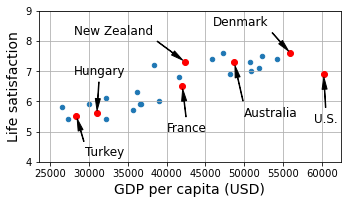

In [ ]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

min_life_sat = 4
max_life_sat = 9

position_text = {
    "Turkey": (29_500, 4.2),
    "Hungary": (28_000, 6.9),
    "France": (40_000, 5),
    "New Zealand": (28_000, 8.2),
    "Australia": (50_000, 5.5),
    "United States": (59_000, 5.3),
    "Denmark": (46_000, 8.5)
}

for country, pos_text in position_text.items():
    pos_data_x = country_stats[gdppc_col].loc[country]
    pos_data_y = country_stats[lifesat_col].loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('money_happy_scatterplot')
plt.show()

In [ ]:
highlighted_countries = country_stats.loc[list(position_text.keys())]
highlighted_countries[[gdppc_col, lifesat_col]].sort_values(by=gdppc_col)

,GDP per capita (USD),Life satisfaction
Country,,
Turkey,28384.987785,5.5
Hungary,31007.768407,5.6
France,42025.617373,6.5
New Zealand,42404.393738,7.3
Australia,48697.837028,7.3
Denmark,55938.212809,7.6
United States,60235.728492,6.9


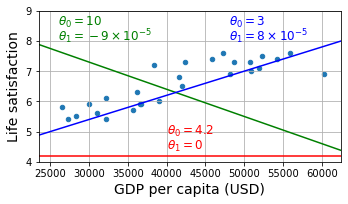

In [ ]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)

w1, w2 = 4.2, 0
plt.plot(X, w1 + w2 * 1e-5 * X, "r")
plt.text(40_000, 4.9, fr"$\theta_0 = {w1}$", color="r")
plt.text(40_000, 4.4, fr"$\theta_1 = {w2}$", color="r")

w1, w2 = 10, -9
plt.plot(X, w1 + w2 * 1e-5 * X, "g")
plt.text(26_000, 8.5, fr"$\theta_0 = {w1}$", color="g")
plt.text(26_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="g")

w1, w2 = 3, 8
plt.plot(X, w1 + w2 * 1e-5 * X, "b")
plt.text(48_000, 8.5, fr"$\theta_0 = {w1}$", color="b")
plt.text(48_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('tweaking_model_params_plot')
plt.show()

In [ ]:
from sklearn import linear_model

X_sample = country_stats[[gdppc_col]].values
y_sample = country_stats[[lifesat_col]].values

lin1 = linear_model.LinearRegression()
lin1.fit(X_sample, y_sample)

t0, t1 = lin1.intercept_[0], lin1.coef_.ravel()[0]
print(f"θ0={t0:.2f}, θ1={t1:.2e}")

θ0=3.75, θ1=6.78e-05


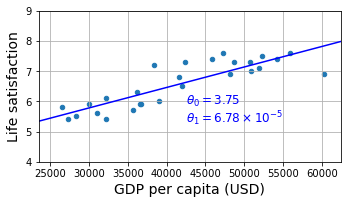

In [ ]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X, t0 + t1 * X, "b")

plt.text(max_gdp - 20_000, min_life_sat + 1.9,
         fr"$\theta_0 = {t0:.2f}$", color="b")
plt.text(max_gdp - 20_000, min_life_sat + 1.3,
         fr"$\theta_1 = {t1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

save_fig('best_fit_model_plot')
plt.show()

In [ ]:
cyprus_gdp_per_capita = gdp_per_capita[gdppc_col].loc["Cyprus"]
cyprus_gdp_per_capita

37655.1803457421

In [ ]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0, 0]
cyprus_predicted_life_satisfaction

6.301656332738056

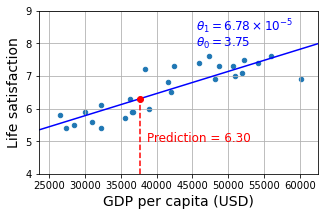

In [ ]:
country_stats.plot(kind='scatter', figsize=(5, 3), grid=True,
                   x=gdppc_col, y=lifesat_col)

X = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X, t0 + t1 * X, "b")

plt.text(min_gdp + 22_000, max_life_sat - 1.1,
         fr"$\theta_0 = {t0:.2f}$", color="b")
plt.text(min_gdp + 22_000, max_life_sat - 0.6,
         fr"$\theta_1 = {t1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita],
         [min_life_sat, cyprus_predicted_life_satisfaction], "r--")
plt.text(cyprus_gdp_per_capita + 1000, 5.0,
         fr"Prediction = {cyprus_predicted_life_satisfaction:.2f}", color="r")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

plt.show()

In [ ]:
missing_data = full_country_stats[(full_country_stats[gdppc_col] < min_gdp) |
                                  (full_country_stats[gdppc_col] > max_gdp)]
missing_data

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5
Norway,63585.903514,7.6
Switzerland,68393.306004,7.5
Ireland,89688.956958,7.0
Luxembourg,110261.157353,6.9


In [ ]:
position_text_missing_countries = {
    "South Africa": (20_000, 4.2),
    "Colombia": (6_000, 8.2),
    "Brazil": (18_000, 7.8),
    "Mexico": (24_000, 7.4),
    "Chile": (30_000, 7.0),
    "Norway": (51_000, 6.2),
    "Switzerland": (62_000, 5.7),
    "Ireland": (81_000, 5.2),
    "Luxembourg": (92_000, 4.7),
}

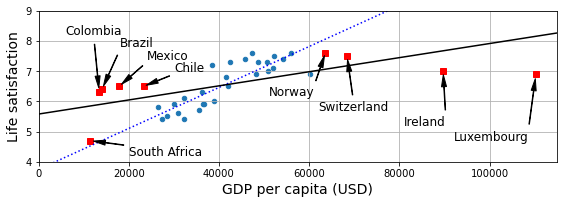

In [ ]:
full_country_stats.plot(kind='scatter', figsize=(8, 3),
                        x=gdppc_col, y=lifesat_col, grid=True)

for country, pos_text in position_text_missing_countries.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0 + t1 * X, "b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats[gdppc_col]]
yfull = np.c_[full_country_stats[lifesat_col]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_.ravel()[0]
X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0full + t1full * X, "k")

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('representative_training_data_scatterplot')
plt.show()

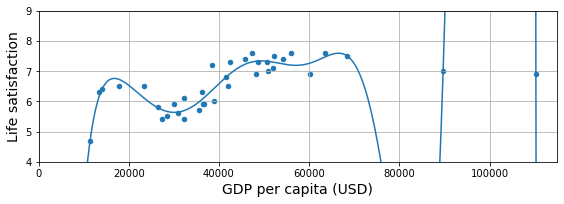

In [ ]:
from sklearn import preprocessing
from sklearn import pipeline

full_country_stats.plot(kind='scatter', figsize=(8, 3),
                        x=gdppc_col, y=lifesat_col, grid=True)

poly = preprocessing.PolynomialFeatures(degree=10, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([
    ('poly', poly),
    ('scal', scaler),
    ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('overfitting_model_plot')
plt.show()

In [ ]:
w_countries = [c for c in full_country_stats.index if "W" in c.upper()]
full_country_stats.loc[w_countries][lifesat_col]

Country
New Zealand    7.3
Sweden         7.3
Norway         7.6
Switzerland    7.5
Name: Life satisfaction, dtype: float64

In [ ]:
all_w_countries = [c for c in gdp_per_capita.index if "W" in c.upper()]
gdp_per_capita.loc[all_w_countries].sort_values(by=gdppc_col)

,GDP per capita (USD)
Country,
Malawi,1486.778248
Rwanda,2098.710362
Zimbabwe,2744.690758
Africa Western and Central,4003.158913
Papua New Guinea,4101.218882
Lower middle income,6722.809932
Eswatini,8392.717564
Low & middle income,10293.855325
Arab World,13753.707307


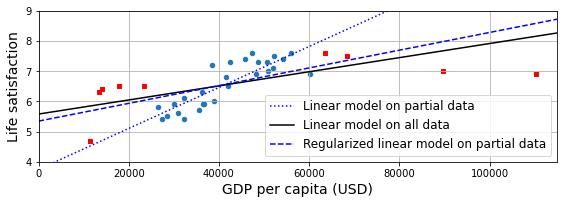

In [ ]:
country_stats.plot(kind='scatter', x=gdppc_col, y=lifesat_col, figsize=(8, 3))
missing_data.plot(kind='scatter', x=gdppc_col, y=lifesat_col,
                  marker="s", color="r", grid=True, ax=plt.gca())

X = np.linspace(0, 115_000, 1000)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")
plt.plot(X, t0full + t1full * X, "k-", label="Linear model on all data")

ridge = linear_model.Ridge(alpha=10**9.5)
X_sample = country_stats[[gdppc_col]]
y_sample = country_stats[[lifesat_col]]
ridge.fit(X_sample, y_sample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_.ravel()[0]
plt.plot(X, t0ridge + t1ridge * X, "b--",
         label="Regularized linear model on partial data")
plt.legend(loc="lower right")

plt.axis([0, 115_000, min_life_sat, max_life_sat])

save_fig('ridge_model_plot')
plt.show()

# Exercise Solutions

1. Machine Learning is about building systems that can learn from data. Learning means getting better at some task, given some performance measure.
2. Machine Learning is great for complex problems for which we have no algorithmic solution, to replace long lists of hand-tuned rules, to build systems that adapt to fluctuating environments, and finally to help humans learn (e.g., data mining).
3. A labeled training set is a training set that contains the desired solution (a.k.a. a label) for each instance.
4. The two most common supervised tasks are regression and classification.
5. Common unsupervised tasks include clustering, visualization, dimensionality reduction, and association rule learning.
6. Reinforcement Learning is likely to perform best if we want a robot to learn to walk in various unknown terrains, since this is typically the type of problem that Reinforcement Learning tackles. It might be possible to express the problem as a supervised or semi-supervised learning problem, but it would be less natural.
7. If you don't know how to define the groups, then you can use a clustering algorithm (unsupervised learning) to segment your customers into clusters of similar customers. However, if you know what groups you would like to have, then you can feed many examples of each group to a classification algorithm (supervised learning), and it will classify all your customers into these groups.
8. Spam detection is a typical supervised learning problem: the algorithm is fed many emails along with their labels (spam or not spam).
9. An online learning system can learn incrementally, as opposed to a batch learning system. This makes it capable of adapting rapidly to both changing data and autonomous systems, and of training on very large quantities of data.
10. Out-of-core algorithms can handle vast quantities of data that cannot fit in a computer's main memory. An out-of-core learning algorithm chops the data into mini-batches and uses online learning techniques to learn from these mini-batches.
11. An instance-based learning system learns the training data by heart; then, when given a new instance, it uses a similarity measure to find the most similar learned instances and uses them to make predictions.
12. A model has one or more model parameters that determine what it will predict given a new instance (e.g., the slope of a linear model). A learning algorithm tries to find optimal values for these parameters such that the model generalizes well to new instances. A hyperparameter is a parameter of the learning algorithm itself, not of the model (e.g., the amount of regularization to apply).
13. Model-based learning algorithms search for an optimal value for the model parameters such that the model will generalize well to new instances. We usually train such systems by minimizing a cost function that measures how bad the system is at making predictions on the training data, plus a penalty for model complexity if the model is regularized. To make predictions, we feed the new instance's features into the model's prediction function, using the parameter values found by the learning algorithm.
14. Some of the main challenges in Machine Learning are the lack of data, poor data quality, nonrepresentative data, uninformative features, excessively simple models that underfit the training data, and excessively complex models that overfit the data.
15. If a model performs great on the training data but generalizes poorly to new instances, the model is likely overfitting the training data (or we got extremely lucky on the training data). Possible solutions to overfitting are getting more data, simplifying the model (selecting a simpler algorithm, reducing the number of parameters or features used, or regularizing the model), or reducing the noise in the training data.
16. A test set is used to estimate the generalization error that a model will make on new instances, before the model is launched in production.
17. A validation set is used to compare models. It makes it possible to select the best model and tune the hyperparameters.
18. The train-dev set is used when there is a risk of mismatch between the training data and the data used in the validation and test datasets (which should always be as close as possible to the data used once the model is in production). The train-dev set is a part of the training set that's held out (the model is not trained on it). The model is trained on the rest of the training set, and evaluated on both the train-dev set and the validation set. If the model performs well on the training set but not on the train-dev set, then the model is likely overfitting the training set. If it performs well on both the training set and the train-dev set, but not on the validation set, then there is probably a significant data mismatch between the training data and the validation + test data, and you should try to improve the training data to make it look more like the validation + test data.
19. If you tune hyperparameters using the test set, you risk overfitting the test set, and the generalization error you measure will be optimistic (you may launch a model that performs worse than you expect).